# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Install Necessary Packages

In [ ]:
!pip install -r requirements.txt

# Import Packages

In [5]:
import os
import random
import torch
import matplotlib.pyplot as plt

from tensornet.data.cleaning import clean_data, split_data
from tensornet.data import Dataset
from tensornet.models import mobilenet_v2
from tensornet.models.loss import cross_entropy_loss
from tensornet.models.optimizer import sgd
from tensornet.engine.ops import ModelCheckpoint
from tensornet.engine.ops.lr_scheduler import reduce_lr_on_plateau
from tensornet.utils import initialize_cuda, plot_metric, get_predictions, save_and_show_result

# Data Cleaning

Following steps will be performed to clean the dataset
- Deletion of non-image files
- Converting PNG and grayscale images to RGB format
- Remove low resolution images

In [ ]:
print('Original dataset count:\n')
for f in os.listdir('dataset'):
    print(f'{f} - {len(os.listdir(os.path.join("dataset", f)))}')

Original dataset count:

flying_birds - 8338
large_quadcopters - 4169
small_quadcopters - 3623
winged_drones - 5675


In [ ]:
# Clean data
clean_data('dataset')

Processing directory flying_birds
Removing corrupt and non-image files...


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Converting PNG and grayscale images to RGB JPG format...
Renaming .jpeg files to .jpg...
Removing images with resolution less than 150 * 150...
Done.

Processing directory large_quadcopters
Removing corrupt and non-image files...
Converting PNG and grayscale images to RGB JPG format...
Renaming .jpeg files to .jpg...
Removing images with resolution less than 150 * 150...
Done.

Processing directory small_quadcopters
Removing corrupt and non-image files...
Converting PNG and grayscale images to RGB JPG format...
Renaming .jpeg files to .jpg...
Removing images with resolution less than 150 * 150...
Done.

Processing directory winged_drones
Removing corrupt and non-image files...
Converting PNG and grayscale images to RGB JPG format...
Renaming .jpeg files to .jpg...
Removing images with resolution less than 150 * 150...
Done.



In [ ]:
print('Cleaned dataset count:\n')
for f in os.listdir('dataset'):
    print(f'{f} - {len(os.listdir(os.path.join("dataset", f)))}')

Cleaned dataset count:

flying_birds - 8115
large_quadcopters - 4097
small_quadcopters - 3137
winged_drones - 5540


## Split Dataset

Split dataset into train and test with 70% images going to training dataset.

In [ ]:
split_data('dataset', 'data', split_value=0.7)

# Set Seed and Get GPU Availability

In [6]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(1)

GPU Available? True


# Dataset

In [7]:
dataset = Dataset(
    train_batch_size=256,
    val_batch_size=256,
    cuda=cuda,
    num_workers=16,
    path='data',
    random_resize_crop=(224, 224),
    scale=(0.4, 1.0),
    horizontal_flip_prob=0.5
)

In [8]:
# Handle class imbalance in dataset
dataset.create_class_imbalance_sampler()

In [9]:
dataset.classes

['flying_birds', 'large_quadcopters', 'small_quadcopters', 'winged_drones']

Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


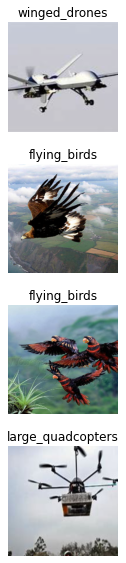

In [ ]:
# Set number of data-points to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    idx = random.randint(0, len(dataset.val_data))

    # Background
    axs[i].axis('off')
    axs[i].set_title(dataset.classes[dataset.val_data[idx][1]])
    axs[i].imshow(dataset.unnormalize(
        dataset.val_data[idx][0], transpose=True
    ))

# Model Architecture and Summary

In [ ]:
model = mobilenet_v2(pretrained=True)

# Change last model layer to contain 4 classes
model.classifier[1] = torch.nn.Linear(1280, 4)
model = model.to(device)

model.summary(dataset.image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# Model Training and Validation

## Create Data Loaders

In [ ]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

## Define Loss Function and Optimizer

In [ ]:
criterion = cross_entropy_loss()
optimizer = sgd(model, learning_rate=0.01, momentum=0.9)

## Define Callbacks

In [ ]:
# Setup Reduce LR on Plateau
scheduler = reduce_lr_on_plateau(
    optimizer, patience=2, verbose=True, min_lr=1e-6
)

# Setup model checkpointing
checkpoint = ModelCheckpoint('checkpoints', monitor='val_accuracy', verbose=1)

## Train Model

In [ ]:
model.fit(
    train_loader, optimizer, criterion,
    device=device, epochs=12, val_loader=val_loader,
    callbacks=[reduce_lr_on_plateau, checkpoint], metrics=['accuracy']
)

Creating a learner object.
Epoch 1:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


11/58 [>.......] - ETA: 11:34 - loss: 0.8700 - accuracy: 45.0745

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


13/58 [>.......] - ETA: 9:59 - loss: 0.8246 - accuracy: 47.5569 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/58 [=>......] - ETA: 7:43 - loss: 0.7837 - accuracy: 50.5700

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


31/58 [===>....] - ETA: 3:23 - loss: 0.6561 - accuracy: 59.3248

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


32/58 [===>....] - ETA: 3:19 - loss: 0.6475 - accuracy: 59.7103

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


35/58 [===>....] - ETA: 3:11 - loss: 0.6291 - accuracy: 60.7954

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 324s 6s/step - loss: 0.5521 - accuracy: 66.4241


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 41 seconds): Average loss: 0.0014, accuracy: 86.19

val_accuracy improved from -inf to 86.19000. Saving model to checkpoints/model.pt

Epoch 2:


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 0/58 [........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 6/58 [........] - ETA: 29:06 - loss: 0.4250 - accuracy: 82.3817

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


22/58 [==>.....] - ETA: 6:53 - loss: 0.3964 - accuracy: 83.2355

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/58 [==>.....] - ETA: 6:04 - loss: 0.3940 - accuracy: 83.3860

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


50/58 [=====>..] - ETA: 56s - loss: 0.3696 - accuracy: 84.2604 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 362s 6s/step - loss: 0.3722 - accuracy: 84.4452


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 31 seconds): Average loss: 0.0016, accuracy: 85.2

Epoch 3:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

 4/58 [........] - ETA: 32:47 - loss: 0.3525 - accuracy: 87.2375

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17/58 [=>......] - ETA: 8:26 - loss: 0.3576 - accuracy: 86.7047

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


18/58 [=>......] - ETA: 8:55 - loss: 0.3556 - accuracy: 86.7044

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


58/58 [========] - 341s 6s/step - loss: 0.3443 - accuracy: 86.6369


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 23 seconds): Average loss: 0.0014, accuracy: 87.21

val_accuracy improved from 86.19000 to 87.21000. Saving model to checkpoints/model.pt

Epoch 4:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


15/58 [=>......] - ETA: 10:27 - loss: 0.3367 - accuracy: 87.4080

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


31/58 [===>....] - ETA: 4:31 - loss: 0.3168 - accuracy: 87.4532

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/58 [===>....] - ETA: 4:17 - loss: 0.3170 - accuracy: 87.4736

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 366s 6s/step - loss: 0.3043 - accuracy: 87.7531


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 8 seconds): Average loss: 0.0013, accuracy: 88.01

val_accuracy improved from 87.21000 to 88.01000. Saving model to checkpoints/model.pt

Epoch 5:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

15/58 [=>......] - ETA: 9:17 - loss: 0.2860 - accuracy: 88.9940 

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


31/58 [===>....] - ETA: 3:50 - loss: 0.2732 - accuracy: 89.0342

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


43/58 [====>...] - ETA: 1:45 - loss: 0.2663 - accuracy: 89.1677

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


47/58 [=====>..] - ETA: 1:11 - loss: 0.2634 - accuracy: 89.2270

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 332s 6s/step - loss: 0.2597 - accuracy: 89.3876


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 26 seconds): Average loss: 0.0013, accuracy: 88.36

val_accuracy improved from 88.01000 to 88.36000. Saving model to checkpoints/model.pt

Epoch 6:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/58 [=>......] - ETA: 8:11 - loss: 0.2573 - accuracy: 90.5147

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/58 [==>.....] - ETA: 5:05 - loss: 0.2462 - accuracy: 90.5088

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 334s 6s/step - loss: 0.2502 - accuracy: 90.6828


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 2 minutes, 54 seconds): Average loss: 0.0014, accuracy: 87.48

Epoch 7:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 3/58 [........] - ETA: 1:05:19 - loss: 0.2600 - accuracy: 90.7700

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/58 [=>......] - ETA: 10:49 - loss: 0.2413 - accuracy: 90.3507

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


27/58 [==>.....] - ETA: 6:05 - loss: 0.2378 - accuracy: 90.5189

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


31/58 [===>....] - ETA: 4:41 - loss: 0.2339 - accuracy: 90.5832

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


58/58 [========] - 384s 7s/step - loss: 0.2297 - accuracy: 90.9169


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 2 minutes, 56 seconds): Average loss: 0.0014, accuracy: 88.68

val_accuracy improved from 88.36000 to 88.68000. Saving model to checkpoints/model.pt

Epoch 8:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 1/58 [........] - ETA: 1:57:26 - loss: 0.2100 - accuracy: 93.3600  

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/58 [=>......] - ETA: 9:12 - loss: 0.2169 - accuracy: 91.8950

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/58 [==>.....] - ETA: 6:09 - loss: 0.2142 - accuracy: 91.9542

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


32/58 [===>....] - ETA: 3:39 - loss: 0.2194 - accuracy: 91.9719

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


35/58 [===>....] - ETA: 3:11 - loss: 0.2194 - accuracy: 91.9674

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


43/58 [====>...] - ETA: 1:50 - loss: 0.2160 - accuracy: 91.9558

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 334s 6s/step - loss: 0.2169 - accuracy: 91.9581


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 53 seconds): Average loss: 0.0013, accuracy: 88.9

val_accuracy improved from 88.68000 to 88.90000. Saving model to checkpoints/model.pt

Epoch 9:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 1/58 [........] - ETA: 2:21:34 - loss: 0.1900 - accuracy: 92.7700  

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 2/58 [........] - ETA: 1:18:13 - loss: 0.2200 - accuracy: 92.2850

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/58 [=>......] - ETA: 8:59 - loss: 0.2160 - accuracy: 91.6513

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/58 [===>....] - ETA: 3:24 - loss: 0.2048 - accuracy: 91.8318

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34/58 [===>....] - ETA: 3:29 - loss: 0.2038 - accuracy: 91.8468

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 333s 6s/step - loss: 0.1991 - accuracy: 92.1216


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 29 seconds): Average loss: 0.0016, accuracy: 86.44

Epoch 10:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 6/58 [........] - ETA: 26:05 - loss: 0.2083 - accuracy: 92.9350

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/58 [=>......] - ETA: 10:10 - loss: 0.1873 - accuracy: 92.8167

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17/58 [=>......] - ETA: 9:41 - loss: 0.1876 - accuracy: 92.8382 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34/58 [===>....] - ETA: 3:52 - loss: 0.1785 - accuracy: 93.0638

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 376s 6s/step - loss: 0.1793 - accuracy: 93.3083


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 34 seconds): Average loss: 0.0014, accuracy: 89.2

val_accuracy improved from 88.90000 to 89.20000. Saving model to checkpoints/model.pt

Epoch 11:
 0/58 [........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 4/58 [........] - ETA: 42:15 - loss: 0.1975 - accuracy: 92.3950

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


32/58 [===>....] - ETA: 3:26 - loss: 0.1884 - accuracy: 92.4731

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 323s 6s/step - loss: 0.1795 - accuracy: 92.7655


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 17 seconds): Average loss: 0.0015, accuracy: 88.42

Epoch 12:


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/58 [>.......] - ETA: 16:20 - loss: 0.1990 - accuracy: 94.3890

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


16/58 [=>......] - ETA: 9:43 - loss: 0.2044 - accuracy: 94.0250 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/58 [========] - 340s 6s/step - loss: 0.1834 - accuracy: 93.4709


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Validation set (took 3 minutes, 8 seconds): Average loss: 0.0015, accuracy: 89.12



Save model to CPU for deployment

In [ ]:
# Load the model with the best validation accuracy
model = torch.load('checkpoints/model.pt')

# Save the model to CPU for deployment
model_deploy = model.to('cpu')
model_deploy = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
model_deploy.save('mobilenetv2.pt')

# Results

Training vs Validation Accuracy

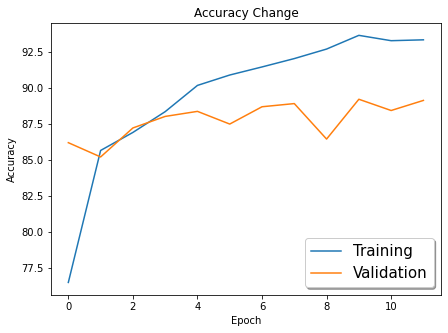

In [ ]:
plot_metric({
    'Training': model.learner.train_metrics[0]['accuracy'],
    'Validation': model.learner.val_metrics[0]['accuracy']
}, 'Accuracy')

## Predictions

In [ ]:
correct_predictions, incorrect_predictions = get_predictions(
    model, val_loader, device, sample_count=10
)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# Convert predictions to numpy array
for idx in range(len(incorrect_predictions)):
    incorrect_predictions[idx]['image'] = dataset.unnormalize(
        incorrect_predictions[idx]['image'], transpose=True
    )
    correct_predictions[idx]['image'] = dataset.unnormalize(
        correct_predictions[idx]['image'], transpose=True
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

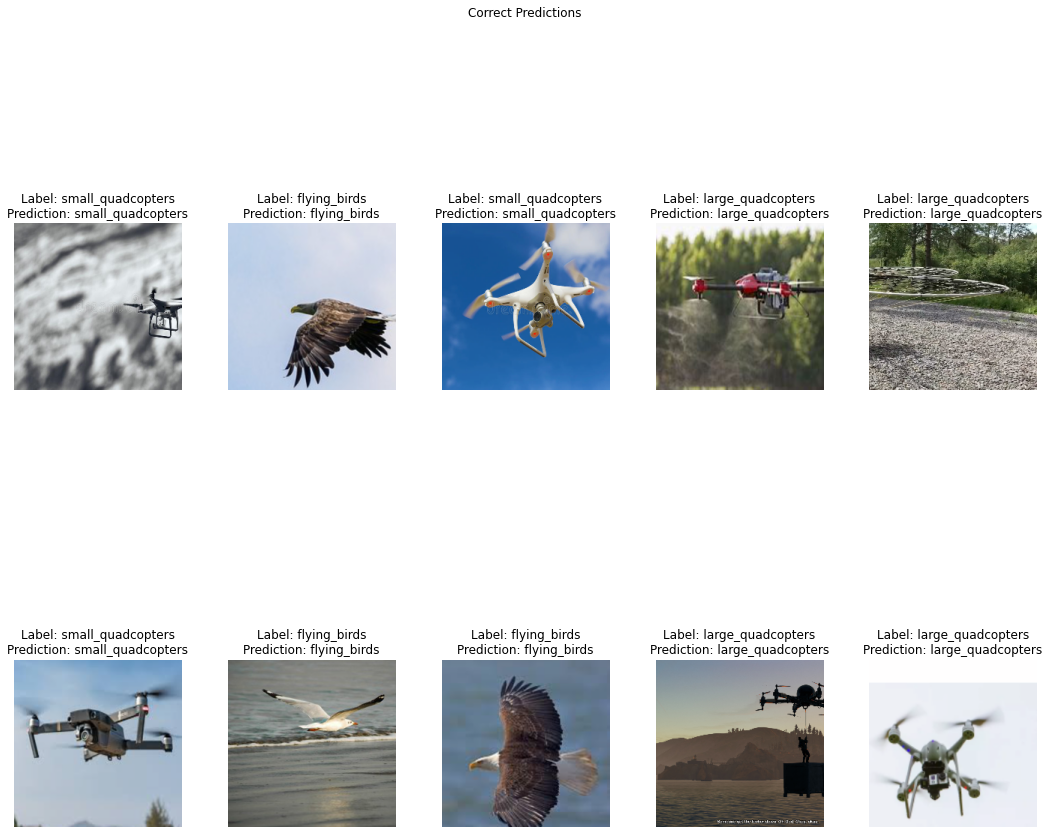

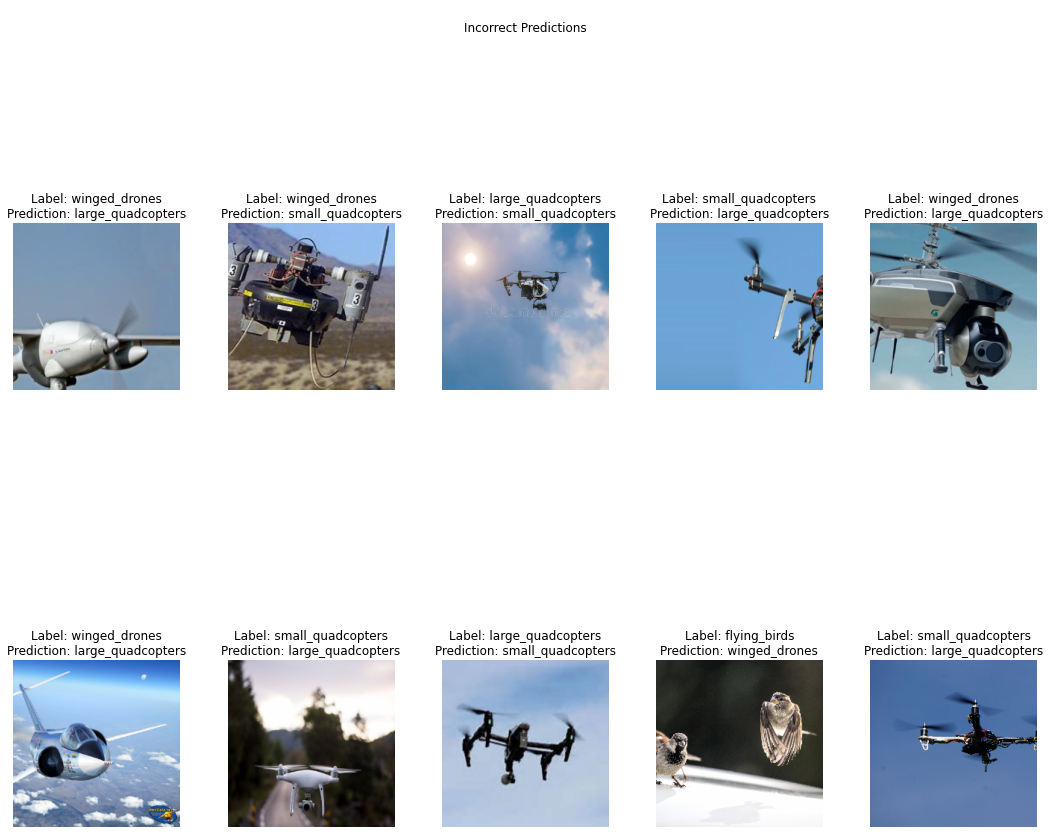

In [ ]:
# Display predictions
save_and_show_result(
    dataset.classes,
    correct_pred=correct_predictions,
    incorrect_pred=incorrect_predictions,
    path='.'
)